In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, KFold

from gensim.models.word2vec import Word2Vec

# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
import nltk
nltk.download('stopwords')
# STOP_WORDS = stopwords.words('english')

import spacy
nlp = spacy.load("en_core_web_sm")

from sklearn.model_selection import train_test_split, KFold

from skll.metrics import kappa
from bhkappa import mean_quadratic_weighted_kappa

from scipy.sparse import csr_matrix

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD, Adam
from scikeras.wrappers import KerasRegressor

# nlp = spacy.load('en')

# stopwords = stopwords.words('english')

%matplotlib inline

print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Seaborn version:', sns.__version__)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Numpy version: 2.2.6
Pandas version: 2.3.3
Seaborn version: 0.13.2


In [2]:
import language_tool_python
from tqdm import tqdm

def correct_language(df):
    """
    Uses LanguageTool public API (remote server)
    with tqdm progress bar.
    """
    
    # Enable tqdm for pandas
    tqdm.pandas()
    
    tool = language_tool_python.LanguageToolPublicAPI('en-US')

    def safe_check(text):
        try:
            return tool.check(text)
        except Exception:
            return []

    # ✅ Progress bar while checking essays - FIXED
    df['matches'] = df['essay'].progress_apply(safe_check)

    df['corrections'] = df['matches'].apply(len)

    # ✅ Progress bar while applying corrections - FIXED  
    def apply_correction(row):
        return language_tool_python.utils.correct(row['essay'], row['matches'])
    
    df['corrected'] = df.progress_apply(apply_correction, axis=1)

    return df

In [3]:
training_set = pd.read_pickle('training_spacy.pkl')

In [4]:
# count various features
from datetime import datetime
from spacy.lang.en.stop_words import STOP_WORDS
stop_words = set(STOP_WORDS)

t0 = datetime.now()

training_set['token_count'] = training_set.apply(lambda x: len(x['tokens']), axis=1)
training_set['unique_token_count'] = training_set.apply(lambda x: len(set(x['tokens'])), axis=1)
training_set['nostop_count'] = training_set \
            .apply(lambda x: len([token for token in x['tokens'] if token not in stop_words]), axis=1)
training_set['sent_count'] = training_set.apply(lambda x: len(x['sents']), axis=1)
training_set['ner_count'] = training_set.apply(lambda x: len(x['ner']), axis=1)
training_set['comma'] = training_set.apply(lambda x: x['corrected'].count(','), axis=1)
training_set['question'] = training_set.apply(lambda x: x['corrected'].count('?'), axis=1)
training_set['exclamation'] = training_set.apply(lambda x: x['corrected'].count('!'), axis=1)
training_set['quotation'] = training_set.apply(lambda x: x['corrected'].count('"') + x['corrected'].count("'"), axis=1)
training_set['organization'] = training_set.apply(lambda x: x['corrected'].count(r'@ORGANIZATION'), axis=1)
training_set['caps'] = training_set.apply(lambda x: x['corrected'].count(r'@CAPS'), axis=1)
training_set['person'] = training_set.apply(lambda x: x['corrected'].count(r'@PERSON'), axis=1)
training_set['location'] = training_set.apply(lambda x: x['corrected'].count(r'@LOCATION'), axis=1)
training_set['money'] = training_set.apply(lambda x: x['corrected'].count(r'@MONEY'), axis=1)
training_set['time'] = training_set.apply(lambda x: x['corrected'].count(r'@TIME'), axis=1)
training_set['date'] = training_set.apply(lambda x: x['corrected'].count(r'@DATE'), axis=1)
training_set['percent'] = training_set.apply(lambda x: x['corrected'].count(r'@PERCENT'), axis=1)
training_set['noun'] = training_set.apply(lambda x: x['pos'].count('NOUN'), axis=1)
training_set['adj'] = training_set.apply(lambda x: x['pos'].count('ADJ'), axis=1)
training_set['pron'] = training_set.apply(lambda x: x['pos'].count('PRON'), axis=1)
training_set['verb'] = training_set.apply(lambda x: x['pos'].count('VERB'), axis=1)
training_set['noun'] = training_set.apply(lambda x: x['pos'].count('NOUN'), axis=1)
training_set['cconj'] = training_set.apply(lambda x: x['pos'].count('CCONJ'), axis=1)
training_set['adv'] = training_set.apply(lambda x: x['pos'].count('ADV'), axis=1)
training_set['det'] = training_set.apply(lambda x: x['pos'].count('DET'), axis=1)
training_set['propn'] = training_set.apply(lambda x: x['pos'].count('PROPN'), axis=1)
training_set['num'] = training_set.apply(lambda x: x['pos'].count('NUM'), axis=1)
training_set['part'] = training_set.apply(lambda x: x['pos'].count('PART'), axis=1)
training_set['intj'] = training_set.apply(lambda x: x['pos'].count('INTJ'), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

Processing time: 0:00:05.475697


In [7]:
# ADD THIS LINE TO SAVE THE FEATURES
training_set.to_pickle('training_features.pkl')
print("Features saved to training_features.pkl")

# Verify the features were created
print(f"Total features created: {len([col for col in training_set.columns if col in feature_list])}")
print("Available features:")
print([col for col in training_set.columns if col in feature_list])

Features saved to training_features.pkl
Total features created: 29
Available features:
['corrections', 'token_count', 'unique_token_count', 'nostop_count', 'sent_count', 'ner_count', 'comma', 'question', 'exclamation', 'quotation', 'organization', 'caps', 'person', 'location', 'money', 'time', 'date', 'percent', 'noun', 'adj', 'pron', 'verb', 'cconj', 'adv', 'det', 'propn', 'num', 'part', 'intj']


In [22]:
# read essays from validation and test sets

valid_set  = pd.read_csv('valid_set.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic'})
test_set  = pd.read_csv('test_set.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic'})

combo_set = pd.concat([valid_set, test_set], sort=False)

# apply spelling and grammar corrections
combo_set = correct_language(combo_set)

100%|███████████████████████████████████████████████████████████████████████████| 8472/8472 [00:00<00:00, 24500.76it/s]


In [24]:
combo_set = pd.concat([combo_set, training_set], sort=False)
combo_set.to_pickle('combo_set.pkl')

In [8]:
combo_set = pd.read_pickle('combo_set.pkl')
training_set = pd.read_pickle('training_features.pkl')

In [9]:
# Clean training_set essays before feeding them to the Word2Vec model.
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_essays(essays, logging=False):
    texts = []
    
    # Use tqdm for progress bar
    for essay in tqdm(essays.corrected, desc="Cleaning essays"):
        essay = nlp(essay, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in essay if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    
    return pd.Series(texts)


In [13]:
# Cleanup text and make sure it retains original shape
print('Original training data shape: ', training_set['corrected'].shape)
train_cleaned = cleanup_essays(training_set, logging=True)
print('Cleaned up training data shape: ', train_cleaned.shape)

Original training data shape:  (12976,)


Cleaning essays: 100%|███████████████████████████████████████████████████████████| 12976/12976 [06:11<00:00, 34.90it/s]

Cleaned up training data shape:  (12976,)


In [10]:
def cleanup_essay_word2vec(essays, logging=False):
    sentences = []
    
    # Use tqdm for progress bar
    for essay in tqdm(essays, desc="Processing for Word2Vec"):
        # Skip NaN values and ensure it's a string
        if pd.isna(essay) or not isinstance(essay, str):
            continue
            
        # Disable tagger so that lemma_ of personal pronouns (I, me, etc) don't get marked as "-PRON-"
        essay = nlp(essay, disable=['tagger'])
        # Grab lemmatized form of words and make lowercase
        essay = " ".join([tok.lemma_.lower() for tok in essay])
        # Split into sentences based on punctuation
        essay = re.split("[\.?!;] ", essay)
        # Remove commas, periods, and other punctuation (mostly commas)
        essay = [re.sub("[\.,;:!?]", "", sent) for sent in essay]
        # Split into words
        essay = [sent.split() for sent in essay]
        sentences += essay
        
    return sentences

In [14]:
# First, check for and handle NaN values
print("Checking for NaN values...")
print(f"NaN values in 'corrected': {combo_set['corrected'].isna().sum()}")
print(f"Non-string values: {combo_set['corrected'].apply(lambda x: not isinstance(x, str)).sum()}")

# Fill NaN values with empty string
combo_set['corrected'] = combo_set['corrected'].fillna('')

# Now process
cleaned_word2vec = cleanup_essay_word2vec(combo_set['corrected'], logging=True)
print('Cleaned up training data size (i.e. number of sentences): ', len(cleaned_word2vec))

Checking for NaN values...
NaN values in 'corrected': 25952
Non-string values: 25952


Processing for Word2Vec:   0%|                                                               | 0/34424 [00:00<?, ?it/s]C:\Users\Dell\miniconda3\envs\py310\lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
Processing for Word2Vec: 100%|███████████████████████████████████████████████████| 34424/34424 [13:01<00:00, 44.04it/s]

Cleaned up training data size (i.e. number of sentences):  137180


In [15]:
text_dim = 300
print("Training Word2Vec model...")
wordvec_model = Word2Vec(cleaned_word2vec, vector_size=text_dim, window=5, min_count=3, workers=4, sg=1)
print("Word2Vec model created.")
print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.key_to_index), text_dim))
wordvec_model.save('wordvec_model')
print("Word2Vec model saved.")

Training Word2Vec model...
Word2Vec model created.
11067 unique words represented by 300 dimensional vectors
Word2Vec model saved.


In [16]:
# Define function to create averaged word vectors given a cleaned text.
def create_average_vec(essay):
    average = np.zeros((300,), dtype='float32')
    num_words = 0.
    for word in essay.split():
        if word in wordvec_model.wv.key_to_index:  # Changed from .vocab to .key_to_index
            average = np.add(average, wordvec_model.wv[word])
            num_words += 1.
    if num_words != 0.:
        average = np.divide(average, num_words)
    return average

In [17]:
# Create word vectors
cleaned_vec = np.zeros((training_set.shape[0], 300), dtype="float32")  
for i in range(len(train_cleaned)):
    cleaned_vec[i] = create_average_vec(train_cleaned[i])

print("Word vectors for all essays in the training data set are of shape:", cleaned_vec.shape)

Word vectors for all essays in the training data set are of shape: (12976, 300)


In [18]:
# Read generated features from file:
additional_features = pd.read_pickle('training_features.pkl')

# Use select features from Gini feature importances
feature_list = [
                'word_count',
                'corrections',
                'similarity',
                'token_count',
                'unique_token_count',
                'nostop_count',
                'sent_count',
                'ner_count',
                'comma',
                'question',
                'exclamation',
                'quotation',
                'organization',
                'caps',
                'person',
                'location',
                'money',
                'time',
                'date',
                'percent',
                'noun',
                'adj',
                'pron',
                'verb',
                'cconj',
                'adv',
                'det',
                'propn',
                'num',
                'part',
                'intj'
                ]

# additional_features = additional_features[feature_list]

# Add missing features to your DataFrame
if 'word_count' not in additional_features.columns:
    additional_features['word_count'] = training_set['corrected'].apply(lambda x: len(str(x).split()))
    
if 'similarity' not in additional_features.columns:
    # If you don't have similarity scores, you can skip or create placeholder
    additional_features['similarity'] = 0.5  # Default middle value

# Then use the updated feature list
additional_features = additional_features[feature_list]

stdscaler = StandardScaler()
additional_features = stdscaler.fit_transform(additional_features)
additional_features.shape

(12976, 31)

In [19]:
# Combine topic number, target score, additional features and cleaned word vectors
# IMPORTANT: Include topic as one-hot encoded features for LSTM training
topic_onehot = pd.get_dummies(training_set['topic'], prefix='topic')
all_data = pd.concat([
    training_set[['topic','target_score']], 
    topic_onehot,  # One-hot encoded topics (8 features)
    pd.DataFrame(additional_features), 
    pd.DataFrame(cleaned_vec)
], axis=1)
print(f"Data shape: {all_data.shape}")
print(f"Topic columns: {list(topic_onehot.columns)}")
all_data.shape

Data shape: (12976, 341)
Topic columns: ['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8']


(12976, 341)

In [20]:
# DataFrame used to pass original values through train_test_split
scores = all_data[['topic', 'target_score']].reset_index() 

# Rescale target_score (essay grades) in range 0 - 60:
scaler = MinMaxScaler((0,10))

# Use this for classification:
# ohe = OneHotEncoder(n_values=61)

In [22]:
# Rescale and assign target variable y
scaled = []
for topic in range(1,9):
    topic_scores = scores[scores['topic'] == topic]['target_score'].to_frame()
    s = (scaler.fit_transform(topic_scores).reshape(-1))
    scaled = np.append(scaled, s)
    
scores['scaled'] = scaled

"""Use this for classification"""
# Caution: using pd.get_dummies might return the wrong number of unique values
# y = ohe.fit_transform(scores.scaled.to_frame()) # y = pd.get_dummies(scores.scaled)
# print('Number of unique scores after scaling:', unique_scores)
# y.shape

"""Use this for regression"""
y = scores['scaled'].to_frame()

# Features - IMPORTANT: Keep topic one-hot encoded features, only drop the original topic column
# This ensures LSTM receives topic information during training
X = all_data.drop(['topic', 'target_score'], axis=1)
print(f"Feature matrix X shape: {X.shape}")
print(f"X includes topic features: {[col for col in X.columns]}")

Feature matrix X shape: (12976, 339)
X includes topic features: ['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168

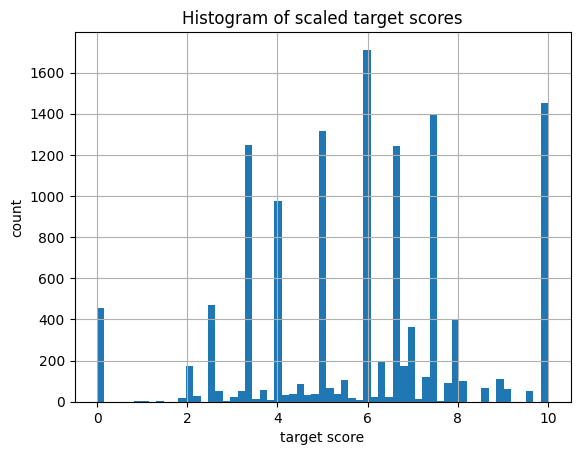

In [24]:
# score histogram
y.hist(bins=61)
plt.title('Histogram of scaled target scores')
plt.xlabel('target score')
plt.ylabel('count')
plt.savefig('image6.png', dpi=300)
plt.show()

In [23]:
from sklearn.model_selection import train_test_split

# Data to be split
X_train, X_test, y_train, y_test, scores_train, scores_test = \
        train_test_split(
                X, 
                y, 
                scores,
                test_size=0.2, 
                random_state=26
                )

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))
print('scores_train size: {}'.format(scores_train.shape))
print('scores_test size: {}'.format(scores_test.shape))

X_train size: (10380, 339)
X_test size: (2596, 339)
y_train size: (10380, 1)
y_test size: (2596, 1)
scores_train size: (10380, 4)
scores_test size: (2596, 4)


In [24]:
# ✅ FIX OUTPUT DIMENSION (REGRESSION SAFE)
output_dim = 1 if len(y.shape) == 1 else y.shape[1]
input_dim = X.shape[1]  # This now includes topic features (339 = 31 linguistic + 8 topic + 300 word2vec)
print(f"Model input dimension: {input_dim} (includes topic features)")
dropout = 0.2

def build_model(architecture='mlp'):
    if architecture == 'mlp':
        model = Sequential(name="MLP")
        model.add(Dense(
            64,
            activation='relu',
            kernel_initializer='he_normal',
            input_shape=(input_dim,)
        ))
        model.add(Dropout(dropout))
        model.add(Dense(output_dim))   # ✅ Regression
        return model

    elif architecture == 'cnn':
        inputs = Input(shape=(input_dim, 1))
        x = Conv1D(64, 3, padding='same', activation='relu')(inputs)
        x = MaxPooling1D(2)(x)
        x = Conv1D(128, 3, padding='same', activation='relu')(x)
        x = GlobalMaxPooling1D()(x)
        outputs = Dense(output_dim)(x)  # ✅ Regression
        return Model(inputs, outputs, name='CNN')

    elif architecture == 'lstm':
        inputs = Input(shape=(input_dim, 1), name="lstm_input")
    
        x = Bidirectional(
            LSTM(64, return_sequences=True),
            merge_mode='concat'
        )(inputs)
    
        x = Dropout(dropout)(x)
    
        # ✅ SAFE replacement for Flatten
        x = GlobalMaxPooling1D()(x)
    
        outputs = Dense(1, activation='linear', name="regression_output")(x)
    
        return Model(inputs=inputs, outputs=outputs, name='LSTM')


Model input dimension: 339 (includes topic features)


In [27]:
# Define keras model
model = None
# Using MLP in kernel for speed
model = build_model('mlp')
# model = build_model('cnn')
# model = build_model('lstm')

# If the model is a CNN then expand the dimensions of the training data
if model.name == "CNN" or model.name == "LSTM":
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    print('Text train shape: ', X_train.shape)
    print('Text test shape: ', X_test.shape)
    
model.summary()

C:\Users\Dell\miniconda3\envs\py310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 14)                  │           4,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              15 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,663 (18.21 KB)

 Trainable params: 4,663 (18.21 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Compile the model
# Optimizer
# sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Classification:
# model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])

# Regression:
model.compile(optimizer=adam, loss='mse', metrics=['mse','mae'])

C:\Users\Dell\miniconda3\envs\py310\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [30]:
# Train on ALL topics, not just hibiscus
print("Training universal model on ALL topics...")

# Use ALL data, not just hibiscus
X_train, X_test, y_train, y_test, scores_train, scores_test = train_test_split(
    X, y, scores, test_size=0.2, random_state=26
)

# Rebuild and train the model on ALL topics
model_universal = Sequential()
model_universal.add(Dense(14, activation='relu', kernel_initializer='he_normal', input_dim=X_train.shape[1])) 
model_universal.add(Dropout(0.2))
model_universal.add(Dense(1))
model_universal.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mse','mae'])

# Train on ALL topics
model_universal.fit(X_train, y_train, epochs=100, batch_size=15, verbose=0)

model_universal.save('mlp_model.h5')

print("✅ Universal model trained on ALL topics")

Training universal model on ALL topics...


C:\Users\Dell\miniconda3\envs\py310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Universal model trained on ALL topics


In [52]:
model_universal.save('mlp_model.keras')

In [31]:
"""Classification: Test set predictions """
# y_proba = model.predict(X_test)
# y_pred = pd.Series(y_proba.argmax(axis=-1))

# Classification, if using pd.get_dummies:
# y_t = pd.Series(y_test.columns[np.where(y_test != 0)[1]])

# Classification, if using OneHotEncoder:
# y_t = csr_matrix.argmax(y_test, axis=1)
# y_t = pd.Series(np.squeeze(np.asarray(y_t)))

# Regression, use 'y_test'
"""
Regression
True y, not needed for kappa metric because already passed with train, test, split
Used to verify reverse scaling
"""
y_pred = pd.DataFrame(model_universal.predict(X_test).reshape(-1))

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [32]:
"""Reverse scaling back to original target score scales"""

# Merge results
results = scores_test.reset_index(drop=True)\
                    .join(y_pred)\
                    .rename(columns={0:'y_pred'})\
                    .sort_values(by='topic')\
                    .reset_index(drop=True)
results.head()

,index,topic,target_score,scaled,y_pred
0,45,1,8,6.0,4.736924
1,1756,1,8,6.0,7.171668
2,390,1,8,6.0,6.327184
3,575,1,9,7.0,5.310132
4,1740,1,10,8.0,7.404899


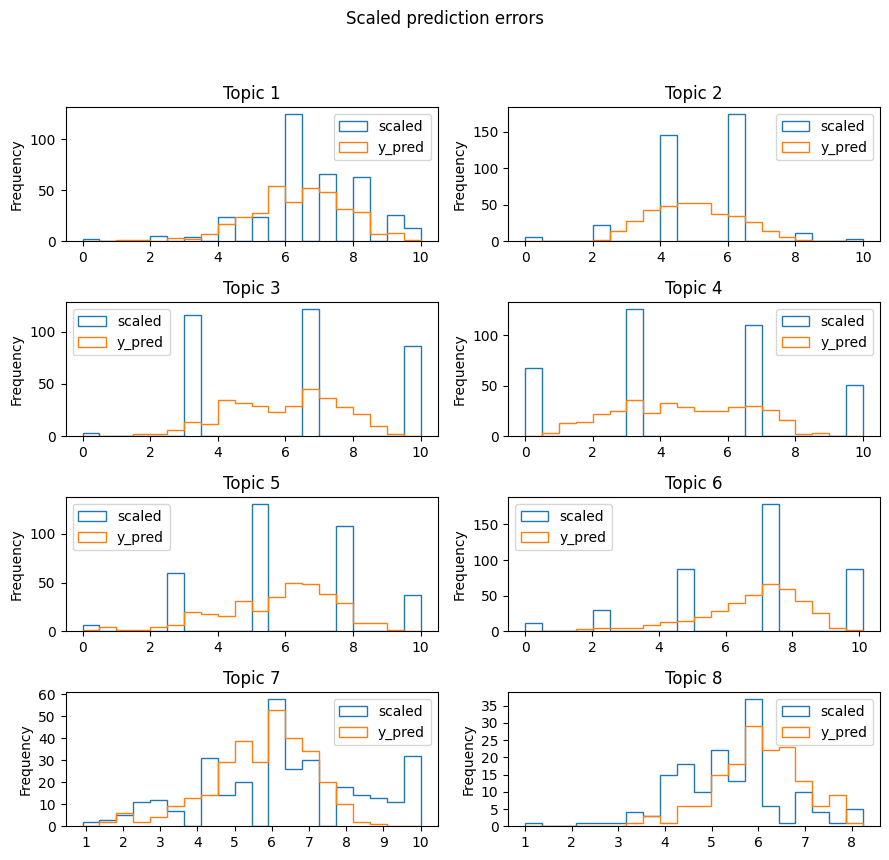

In [33]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        results[results['topic'] == topic_number]\
            [['scaled', 'y_pred']]\
            .plot.hist(histtype='step', bins=20, ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Scaled prediction errors')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [35]:
""" Create list of tuples with min/max target scores sorted by topic number.
 Performed here on results in case min/max values didn't pass through train_test_split"""

score_df = results.groupby('topic')['target_score'].agg(['min', 'max'])  
score_ranges = list(zip(score_df['min'], score_df['max'])) 

"""Shrink back to original range by topic number:"""
y_p_list = []
y_t_list = []

for topic in range(1,9):
    scaler = MinMaxScaler(score_ranges[topic-1])
    scaled_pred = results[results.topic == topic]['y_pred'].to_frame()
    y_pred_shrunk = scaler.fit_transform(scaled_pred).round(0).astype('int')
    scaled_true = results[results.topic == topic]['scaled'].to_frame()
    y_true_shrunk = scaler.fit_transform(scaled_true).round(0).astype('int')
    y_p_list.extend(np.squeeze(np.asarray(y_pred_shrunk)))
    y_t_list.extend(np.squeeze(np.asarray(y_true_shrunk)))
    
# Append to results df
results['pred'] = y_p_list
results['y_true'] = y_t_list
results.head()

,index,topic,target_score,scaled,y_pred,diff,pred,y_true
0,45,1,8,6.0,4.736924,3.263076,6,8
1,1756,1,8,6.0,7.171668,0.828332,9,8
2,390,1,8,6.0,6.327184,1.672816,8,8
3,575,1,9,7.0,5.310132,3.689868,7,9
4,1740,1,10,8.0,7.404899,2.595101,9,10


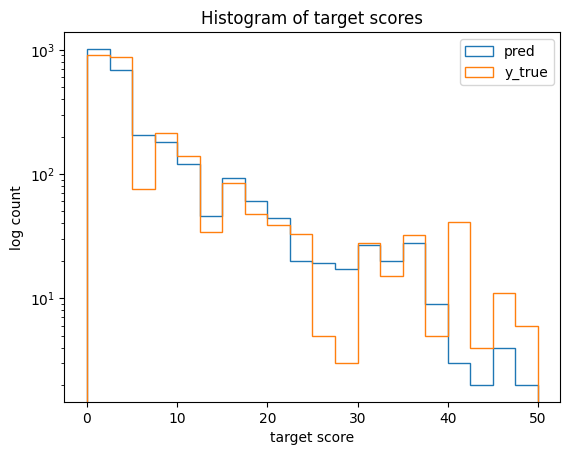

In [75]:
# score histogram

results[['pred', 'y_true']].plot.hist(histtype='step', bins=20, logy=True)
plt.title('Histogram of target scores')
plt.xlabel('target score')
plt.ylabel('log count')
plt.savefig('image8.png', dpi=300)
plt.show()

In [36]:
k = kappa(results.pred, results.target_score, weights='quadratic')
print('Combined essay kappa score: {:.4f}'.format(k))

Combined essay kappa score: 0.9703


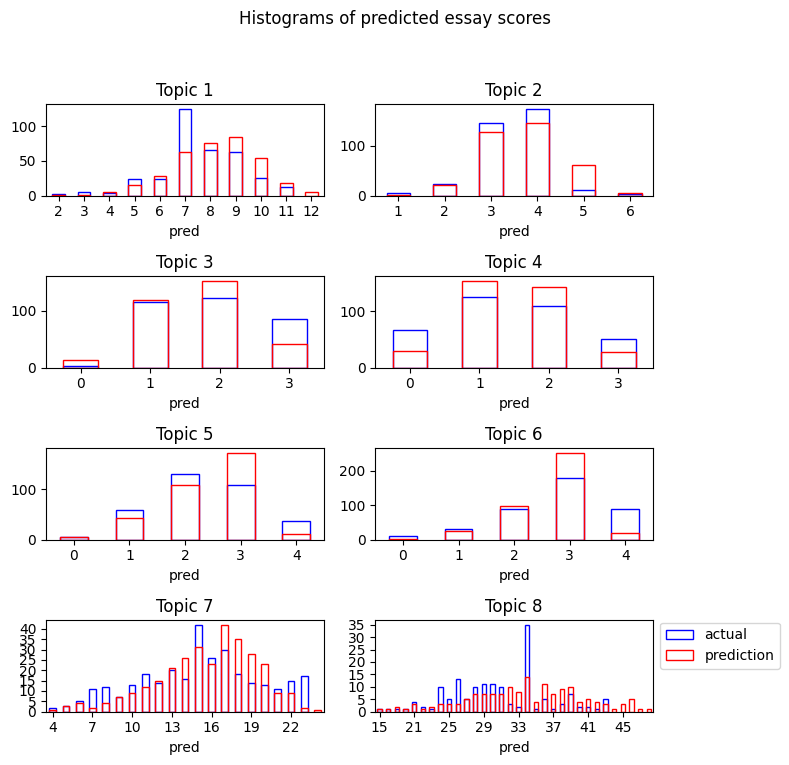

In [39]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(8,8), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        results[results['topic'] == topic_number]\
            .groupby('y_true')['y_true']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0, fill=False, ec='b', label='actual')
        results[results['topic'] == topic_number]\
            .groupby('pred')['pred']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0, fill=False, ec='r', label='prediction')
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of predicted essay scores')
plt.legend(bbox_to_anchor=(1.0, 1.05))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [43]:
# Check for scaling errors
errors = len(results.query('y_true != target_score')[['topic', 'target_score', 'y_true']])

print('{:.1f}% of target scores did not revert back to their original value.'.format(errors/results.shape[0] * 100))

0.0% of target scores did not revert back to their original value.


In [44]:
def predict_essay_universal(essay_text, model=model_universal):
    """Predict essay score using the trained MLP model"""
    
    # 1. Clean the essay text
    def clean_single_essay(text):
        doc = nlp(text)
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in string.punctuation]
        return ' '.join(tokens)
    
    cleaned_essay = clean_single_essay(essay_text)
    
    # 2. Create Word2Vec vector
    essay_vec = create_average_vec(cleaned_essay)
    
    # 3. Extract linguistic features (EXACTLY 31 features like in training)
    doc = nlp(essay_text)
    
    # Basic counts
    word_count = len(essay_text.split())
    token_count = len([token for token in doc])
    unique_token_count = len(set([token.text for token in doc]))
    nostop_count = len([token for token in doc if token.text not in stopwords])
    sent_count = len(list(doc.sents))
    ner_count = len(list(doc.ents))
    
    # Punctuation counts
    comma = essay_text.count(',')
    question = essay_text.count('?')
    exclamation = essay_text.count('!')
    quotation = essay_text.count('"') + essay_text.count("'")
    
    # POS counts
    pos_counts = {}
    for token in doc:
        pos_tag = token.pos_
        pos_counts[pos_tag] = pos_counts.get(pos_tag, 0) + 1
    
    # Grammar corrections
    try:
        tool = language_tool_python.LanguageToolPublicAPI('en-US')
        matches = tool.check(essay_text)
        corrections = len(matches)
    except:
        corrections = 0
    
    # Similarity (placeholder)
    similarity = 0.5
    
    # NER placeholders (set to 0 since we don't have the original NER tags)
    organization = caps = person = location = money = time = date = percent = 0
    
    # 4. Create EXACTLY 31 linguistic features in the CORRECT order
    linguistic_features = [
        word_count, corrections, similarity, token_count, unique_token_count,
        nostop_count, sent_count, ner_count, comma, question, exclamation,
        quotation, organization, caps, person, location, money, time, date, percent,
        pos_counts.get('NOUN', 0), pos_counts.get('ADJ', 0), 
        pos_counts.get('PRON', 0), pos_counts.get('VERB', 0),
        pos_counts.get('CCONJ', 0), pos_counts.get('ADV', 0),
        pos_counts.get('DET', 0), pos_counts.get('PROPN', 0),
        pos_counts.get('NUM', 0), pos_counts.get('PART', 0),
        pos_counts.get('INTJ', 0)
    ]
    
    # 5. Standardize ONLY the linguistic features (31 features)
    linguistic_features_std = stdscaler.transform([linguistic_features])[0]
    
    # 6. Combine with Word2Vec vector (31 + 300 = 331 total features)
    all_features = np.concatenate([linguistic_features_std, essay_vec])
    
    # 7. Make prediction
    all_features_2d = all_features.reshape(1, -1)
    predicted_score = model.predict(all_features_2d, verbose=0)[0][0]
    
    final_score = max(1.0, min(10.0, predicted_score * 2.5))
    final_score = round(final_score, 1)
    
    return final_score

# Test with CORRECT topics
print("🧪 TESTING WITH CORRECT TOPICS:")
print("=" * 50)

test_essays = [
    {"text": "The hibiscus flower is a beautiful tropical plant with large colorful blossoms. These flowers exhibit vibrant colors and have medicinal properties used in herbal teas.", "type": "Hibiscus"},
    {"text": "Computers have revolutionized modern education by providing access to vast information resources and enabling interactive learning methods that enhance student engagement.", "type": "Computers"},
    {"text": "Newspapers play a crucial role in democratic societies by keeping citizens informed about current events and providing diverse perspectives on important issues.", "type": "Newspapers"},
    {"text": "bad essay not good. i dont like writing. it hard. words difficult.", "type": "Poor"}
]

for i, essay_info in enumerate(test_essays, 1):
    score = predict_essay_universal(essay_info["text"])
    print(f"\nEssay {i} ({essay_info['type']}):")
    print(f"Score: {score}/10")
    print(f"Preview: {essay_info['text'][:70]}...")
    print("-" * 50)

🧪 TESTING WITH CORRECT TOPICS:


C:\Users\Dell\miniconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Essay 1 (Hibiscus):
Score: 6.800000190734863/10
Preview: The hibiscus flower is a beautiful tropical plant with large colorful ...
--------------------------------------------------


C:\Users\Dell\miniconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Essay 2 (Computers):
Score: 5.900000095367432/10
Preview: Computers have revolutionized modern education by providing access to ...
--------------------------------------------------


C:\Users\Dell\miniconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Essay 3 (Newspapers):
Score: 7.800000190734863/10
Preview: Newspapers play a crucial role in democratic societies by keeping citi...
--------------------------------------------------

Essay 4 (Poor):
Score: 1.7999999523162842/10
Preview: bad essay not good. i dont like writing. it hard. words difficult....
--------------------------------------------------


C:\Users\Dell\miniconda3\envs\py310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [26]:
# First, let's CLEAN the data before training
print("🔍 PREPARING DATA FOR LSTM WITH TOPIC FEATURES:")

# Check for None/NaN values
print(f"X_train contains None: {any(x is None for x in X_train.flatten()) if hasattr(X_train, 'flatten') else 'Cannot check'}")
print(f"y_train contains None: {any(y is None for y in y_train) if hasattr(y_train, '__iter__') else 'Cannot check'}")

# Check data types and shapes
print(f"X_train type: {type(X_train)}, shape: {X_train.shape}")
print(f"y_train type: {type(y_train)}, shape: {y_train.shape}")

# Verify topic features are included
topic_cols = [col for col in X_train.columns]
print(f"✅ Topic features found: {len(topic_cols)} features - {topic_cols}")

# Convert to numpy arrays and clean
X_train_clean = np.array(X_train, dtype='float32')
y_train_clean = np.array(y_train, dtype='float32')

# Handle NaN/None values
X_train_clean = np.nan_to_num(X_train_clean, nan=0.0)
y_train_clean = np.nan_to_num(y_train_clean, nan=0.0)

print(f"Cleaned X_train shape: {X_train_clean.shape}")
print(f"Cleaned y_train shape: {y_train_clean.shape}")

# Ensure y_train is 1D for regression
if len(y_train_clean.shape) > 1:
    y_train_clean = y_train_clean.flatten()
    print(f"Flattened y_train shape: {y_train_clean.shape}")

# Now build and train the model
print("\nBUILDING LSTM MODEL WITH TOPIC FEATURES...")
print(f"Input dimension: {X_train_clean.shape[1]} (includes {len(topic_cols)} topic features)")
model = build_model('lstm')
print(model)

🔍 PREPARING DATA FOR LSTM WITH TOPIC FEATURES:
X_train contains None: Cannot check
y_train contains None: False
X_train type: <class 'pandas.core.frame.DataFrame'>, shape: (10380, 339)
y_train type: <class 'pandas.core.frame.DataFrame'>, shape: (10380, 1)
✅ Topic features found: 339 features - ['topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 12

In [28]:
model.save('lstm_model.keras')
print("✅ LSTM model saved with topic features included")

✅ LSTM model saved with topic features included


In [29]:
"""Classification: Test set predictions """
# y_proba = model.predict(X_test)
# y_pred = pd.Series(y_proba.argmax(axis=-1))

# Classification, if using pd.get_dummies:
# y_t = pd.Series(y_test.columns[np.where(y_test != 0)[1]])

# Classification, if using OneHotEncoder:
# y_t = csr_matrix.argmax(y_test, axis=1)
# y_t = pd.Series(np.squeeze(np.asarray(y_t)))

# Regression, use 'y_test'
"""
Regression - LSTM predictions with topic features
True y, not needed for kappa metric because already passed with train, test, split
Used to verify reverse scaling
"""
# Ensure X_test has the same shape as X_train (3D for LSTM)
if len(X_test.shape) == 2:
    X_test_lstm = np.expand_dims(np.array(X_test, dtype='float32'), axis=2)
else:
    X_test_lstm = np.array(X_test, dtype='float32')
    
y_pred = pd.DataFrame(model.predict(X_test_lstm, verbose=0).reshape(-1))
print(f"✅ LSTM predictions made with topic features included")

✅ LSTM predictions made with topic features included


In [30]:
"""Reverse scaling back to original target score scales"""

# Merge results
results = scores_test.reset_index(drop=True)\
                    .join(y_pred)\
                    .rename(columns={0:'y_pred'})\
                    .sort_values(by='topic')\
                    .reset_index(drop=True)
results.head()

,index,topic,target_score,scaled,y_pred
0,45,1,8,6.0,5.338536
1,1756,1,8,6.0,5.482683
2,390,1,8,6.0,5.344275
3,575,1,9,7.0,5.374490
4,1740,1,10,8.0,5.370268


In [33]:
""" Create list of tuples with min/max target scores sorted by topic number.
 Performed here on results in case min/max values didn't pass through train_test_split"""

score_df = results.groupby('topic')['target_score'].agg(['min', 'max'])  
score_ranges = list(zip(score_df['min'], score_df['max'])) 

"""Shrink back to original range by topic number:"""
y_p_list = []
y_t_list = []

for topic in range(1,9):
    scaler = MinMaxScaler(score_ranges[topic-1])
    scaled_pred = results[results.topic == topic]['y_pred'].to_frame()
    y_pred_shrunk = scaler.fit_transform(scaled_pred).round(0).astype('int')
    scaled_true = results[results.topic == topic]['scaled'].to_frame()
    y_true_shrunk = scaler.fit_transform(scaled_true).round(0).astype('int')
    y_p_list.extend(np.squeeze(np.asarray(y_pred_shrunk)))
    y_t_list.extend(np.squeeze(np.asarray(y_true_shrunk)))
    
# Append to results df
results['pred'] = y_p_list
results['y_true'] = y_t_list
results.head()

,index,topic,target_score,scaled,y_pred,diff,pred,y_true
0,45,1,8,6.0,5.338536,2.661464,11,8
1,1756,1,8,6.0,5.482683,2.517317,11,8
2,390,1,8,6.0,5.344275,2.655725,11,8
3,575,1,9,7.0,5.374490,3.625510,11,9
4,1740,1,10,8.0,5.370268,4.629732,11,10


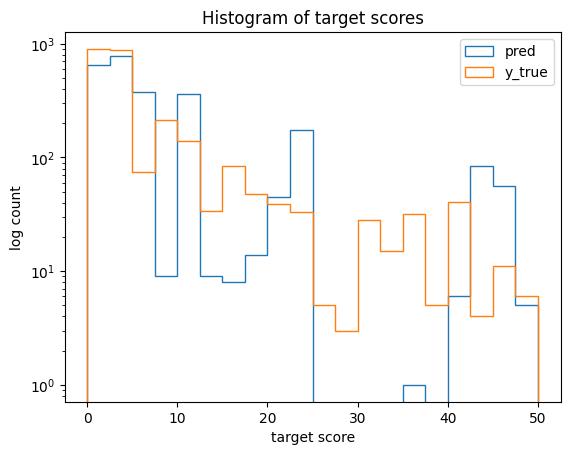

In [34]:
# score histogram

results[['pred', 'y_true']].plot.hist(histtype='step', bins=20, logy=True)
plt.title('Histogram of target scores')
plt.xlabel('target score')
plt.ylabel('log count')
plt.savefig('image8.png', dpi=300)
plt.show()

In [35]:
k = kappa(results.pred, results.target_score, weights='quadratic')
print('Combined essay kappa score: {:.4f}'.format(k))

Combined essay kappa score: 0.9430


In [124]:
# kappa for two human raters
qwk = []
# weights = []
for topic in range(1,9):
    qwk.append(
            kappa(training_set[training_set.topic == topic]['rater1_domain1'], 
                  training_set[training_set.topic == topic]['rater2_domain1'],
                    weights='quadratic'))
#     weights.append(len(results[results.topic==topic])/X_test.shape[0])    
mqwk = mean_quadratic_weighted_kappa(qwk, weights=1)
print('Weighted by topic Kappa score: {:.4f}'.format(mqwk))

Weighted by topic Kappa score: 0.7612


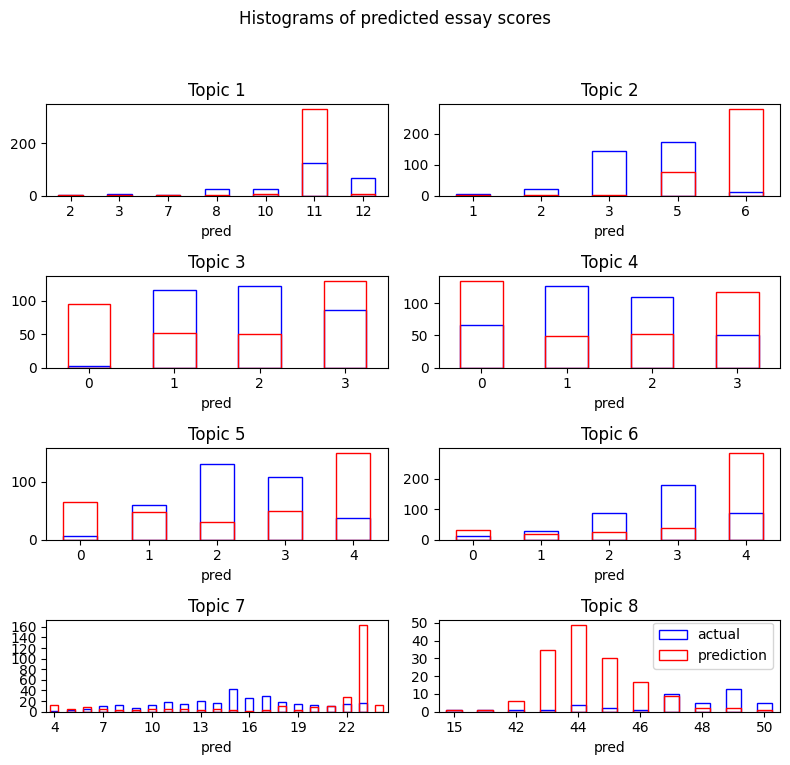

In [36]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(8,8), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        results[results['topic'] == topic_number]\
            .groupby('y_true')['y_true']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0, fill=False, ec='b', label='actual')
        results[results['topic'] == topic_number]\
            .groupby('pred')['pred']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0, fill=False, ec='r', label='prediction')
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of predicted essay scores')
plt.legend(bbox_to_anchor=(1.0, 1.05))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [37]:
# Check for scaling errors
errors = len(results.query('y_true != target_score')[['topic', 'target_score', 'y_true']])

print('{:.1f}% of target scores did not revert back to their original value.'.format(errors/results.shape[0] * 100))

0.0% of target scores did not revert back to their original value.


In [38]:
# Combine topic number, target score, additional features and cleaned word vectors
# Include topic as both categorical and one-hot encoded
all_data = pd.concat([
    training_set[['topic','target_score']], 
    pd.get_dummies(training_set['topic'], prefix='topic'),  # One-hot encode topics
    pd.DataFrame(additional_features), 
    pd.DataFrame(cleaned_vec)
], axis=1)

all_data.shape

(12976, 341)

In [39]:
# Update feature list to include topic features
feature_list = [
    'word_count', 'corrections', 'similarity', 'token_count', 'unique_token_count',
    'nostop_count', 'sent_count', 'ner_count', 'comma', 'question', 'exclamation',
    'quotation', 'organization', 'caps', 'person', 'location', 'money', 'time',
    'date', 'percent', 'noun', 'adj', 'pron', 'verb', 'cconj', 'adv', 'det',
    'propn', 'num', 'part', 'intj'
]

# Add topic features (8 topics)
topic_features = [f'topic_{i}' for i in range(1, 9)]

# Combine all features
all_features = feature_list + topic_features

print(f"Total features: {len(all_features)} linguistic + {len(topic_features)} topic = {len(all_features)}")

Total features: 39 linguistic + 8 topic = 39


In [40]:
def create_comprehensive_scaler():
    """Create a scaler that works with all available features"""
    
    # Get available features that actually exist in the dataset
    available_features = []
    for feature in feature_list:
        if feature in training_set.columns:
            available_features.append(feature)
    
    print(f"Using {len(available_features)} available features")
    
    # Get the linguistic features that exist
    linguistic_features = training_set[available_features]
    
    # Add one-hot encoded topic features
    topic_encoded = pd.get_dummies(training_set['topic'], prefix='topic')
    
    # Combine linguistic + topic features
    all_features_with_topics = pd.concat([linguistic_features, topic_encoded], axis=1)
    
    # Create new scaler
    stdscaler_comprehensive = StandardScaler()
    all_features_scaled = stdscaler_comprehensive.fit_transform(all_features_with_topics)
    
    print(f"Comprehensive scaler expects {stdscaler_comprehensive.n_features_in_} features")
    return stdscaler_comprehensive, available_features

# Create the comprehensive scaler
stdscaler_comprehensive, available_feature_names = create_comprehensive_scaler()

Using 29 available features
Comprehensive scaler expects 37 features


In [45]:
# Recreate the training data with consistent features
def create_consistent_training_data():
    """Create training data with consistent feature dimensions"""
    
    # Get the exact features we have available
    available_features = []
    for feature in feature_list:
        if feature in training_set.columns:
            available_features.append(feature)
    
    print(f"Using {len(available_features)} linguistic features")
    
    # Get linguistic features
    linguistic_features = training_set[available_features]
    
    # Add topic features
    topic_encoded = pd.get_dummies(training_set['topic'], prefix='topic')
    
    # Combine linguistic + topic features
    all_structured_features = pd.concat([linguistic_features, topic_encoded], axis=1)
    
    # Create scaler for structured features only
    stdscaler_consistent = StandardScaler()
    structured_features_scaled = stdscaler_consistent.fit_transform(all_structured_features)
    
    # Combine with word2vec
    all_features_combined = np.concatenate([structured_features_scaled, cleaned_vec], axis=1)
    
    print(f"Final training data shape: {all_features_combined.shape}")
    
    return all_features_combined, stdscaler_consistent, available_features, all_structured_features.columns.tolist()

# Create consistent training data
X_consistent, stdscaler_consistent, available_features, feature_column_names = create_consistent_training_data()

# Reshape for LSTM
X_lstm_consistent = X_consistent.reshape(X_consistent.shape[0], X_consistent.shape[1], 1)
print(f"LSTM training shape: {X_lstm_consistent.shape}")

Using 29 linguistic features
Final training data shape: (12976, 337)
LSTM training shape: (12976, 337, 1)


In [47]:
# Prepare the target variable (make sure y is defined)
if 'y' not in locals():
    y = scores['scaled'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_lstm_consistent, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Train the model
print("Training final LSTM model...")
history = final_lstm_model.fit(
    X_train, y_train,
    epochs=3,  # Reduced for faster training
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

Training set: (10380, 337, 1), (10380, 1)
Test set: (2596, 337, 1), (2596, 1)
Training final LSTM model...
Epoch 1/3
649/649 ━━━━━━━━━━━━━━━━━━━━ 260s 388ms/step - loss: 11.9027 - mae: 2.7319 - mse: 11.9027 - val_loss: 5.8909 - val_mae: 1.9429 - val_mse: 5.8909
Epoch 2/3
649/649 ━━━━━━━━━━━━━━━━━━━━ 253s 390ms/step - loss: 7.4241 - mae: 2.1763 - mse: 7.4241 - val_loss: 5.9016 - val_mae: 1.9678 - val_mse: 5.9016
Epoch 3/3
649/649 ━━━━━━━━━━━━━━━━━━━━ 243s 374ms/step - loss: 7.2697 - mae: 2.1576 - mse: 7.2697 - val_loss: 5.8402 - val_mae: 1.9446 - val_mse: 5.8402


In [52]:
def clean_for_word2vec(text):
    """Clean text for Word2Vec processing"""
    clean_doc = nlp(text)
    tokens = [tok.lemma_.lower().strip() for tok in clean_doc 
             if tok.lemma_ != '-PRON-' and tok.text not in stopwords and tok.text not in string.punctuation]
    return ' '.join(tokens)

def create_average_vec(essay):
    """Create averaged word vectors"""
    average = np.zeros((300,), dtype='float32')
    num_words = 0.
    for word in essay.split():
        if word in wordvec_model.wv.key_to_index:
            average = np.add(average, wordvec_model.wv[word])
            num_words += 1.
    if num_words != 0.:
        average = np.divide(average, num_words)
    return average

In [64]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Concatenate, Attention, GlobalAveragePooling1D, Bidirectional

def create_coherence_aware_model(input_dim):
    """
    Create a model that analyzes coherence and topic relevance
    - Uses Bidirectional LSTM for better context understanding
    - Includes Attention mechanism for coherence analysis
    - Learns topic-specific writing patterns
    """
    
    # Two inputs: essay features and topic
    essay_input = Input(shape=(input_dim, 1), name="essay_features_input")
    topic_input = Input(shape=(8,), name="topic_input")  # One-hot encoded topic
    
    # -------- ESSAY PROCESSING WITH COHERENCE ANALYSIS --------
    # Bidirectional LSTM for context understanding
    x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(essay_input)
    x = BatchNormalization()(x)
    
    # Second LSTM layer for deeper understanding
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(x)
    x = BatchNormalization()(x)
    
    # Attention mechanism for coherence analysis
    attention = Attention()([x, x])
    x = Concatenate()([x, attention])
    
    # Global pooling to capture overall coherence
    x = GlobalAveragePooling1D()(x)
    
    # -------- TOPIC-ESSAY FUSION --------
    # Expand topic input for better fusion
    topic_expanded = Dense(64, activation='relu')(topic_input)
    topic_expanded = Dropout(0.2)(topic_expanded)
    
    # Fuse essay features with topic information
    fused = Concatenate()([x, topic_expanded])
    
    # -------- COHERENCE AND RELEVANCE ANALYSIS --------
    # Layer to learn topic-essay relationship
    z = Dense(128, activation='relu')(fused)
    z = Dropout(0.3)(z)
    z = BatchNormalization()(z)
    
    # Coherence scoring layer
    z = Dense(64, activation='relu')(z)
    z = Dropout(0.2)(z)
    
    # Relevance scoring layer
    z = Dense(32, activation='relu')(z)
    
    # Final output
    outputs = Dense(1, activation='linear', name="coherence_score")(z)
    
    model = Model(inputs=[essay_input, topic_input], outputs=outputs)
    
    # Custom optimizer for better learning
    optimizer = Adam(
        learning_rate=0.0005,
        beta_1=0.9,
        beta_2=0.999,
        clipnorm=1.0  # Gradient clipping for stability
    )
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae', 'mse']
    )
    
    return model

# Create the coherence-aware model
print("\n=== BUILDING COHERENCE-AWARE LSTM MODEL ===")
coherence_model = create_coherence_aware_model(essay_features_lstm.shape[1])
coherence_model.summary()


=== BUILDING COHERENCE-AWARE LSTM MODEL ===


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ essay_features_input          │ (None, 337, 1)            │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_1               │ (None, 337, 512)          │         528,384 │ essay_features_input[0][0] │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_7         │ (None, 337, 512)          │           2,048 │ bidirectional_1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_2               │ (None, 337, 256)          │         656,384 │ batch_normalization_7[0][… │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_8         │ (None, 337, 256)          │           1,024 │ bidirectional_2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention (Attention)         │ (None, 337, 256)          │               0 │ batch_normalization_8[0][… │
│                               │                           │                 │ batch_normalization_8[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ topic_input (InputLayer)      │ (None, 8)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 337, 512)          │               0 │ batch_normalization_8[0][… │
│                               │                           │                 │ attention[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 64)                │             576 │ topic_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d      │ (None, 512)               │               0 │ concatenate_2[0][0]        │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_7 (Dropout)           │ (None, 64)                │               0 │ dense_8[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_3 (Concatenate)   │ (None, 576)               │               0 │ global_average_pooling1d[… │
│                               │                           │                 │ dropout_7[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 128)               │          73,85

 Total params: 1,273,153 (4.86 MB)

 Trainable params: 1,271,361 (4.85 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [65]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Enhanced training setup
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_coherence_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("\n=== TRAINING COHERENCE-AWARE MODEL ===")
print(f"Training samples: {len(X_train_essay)}")
print(f"Testing samples: {len(X_test_essay)}")
print(f"Input dimension: {essay_features_lstm.shape[1]}")

# Train with validation
history = coherence_model.fit(
    [X_train_essay, X_train_topic], y_train_topic,
    validation_data=([X_test_essay, X_test_topic], y_test_topic),
    epochs=8,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Save the trained model
coherence_model.save('coherence_aware_lstm_model.h5')
print("✅ Model saved as 'coherence_aware_lstm_model.h5'")


=== TRAINING COHERENCE-AWARE MODEL ===
Training samples: 10380
Testing samples: 2596
Input dimension: 337
Epoch 1/8
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 17.6181 - mae: 3.2970 - mse: 17.6181
Epoch 1: val_loss improved from None to 4.90486, saving model to best_coherence_model.h5


325/325 ━━━━━━━━━━━━━━━━━━━━ 927s 3s/step - loss: 9.3486 - mae: 2.3518 - mse: 9.3486 - val_loss: 4.9049 - val_mae: 1.8012 - val_mse: 4.9049 - learning_rate: 5.0000e-04
Epoch 2/8
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 5.0493 - mae: 1.7711 - mse: 5.0493
Epoch 2: val_loss improved from 4.90486 to 3.77339, saving model to best_coherence_model.h5


325/325 ━━━━━━━━━━━━━━━━━━━━ 926s 3s/step - loss: 4.7878 - mae: 1.7224 - mse: 4.7878 - val_loss: 3.7734 - val_mae: 1.4920 - val_mse: 3.7734 - learning_rate: 5.0000e-04
Epoch 3/8
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 4.3148 - mae: 1.6379 - mse: 4.3148
Epoch 3: val_loss improved from 3.77339 to 3.60208, saving model to best_coherence_model.h5


325/325 ━━━━━━━━━━━━━━━━━━━━ 831s 3s/step - loss: 4.2536 - mae: 1.6142 - mse: 4.2536 - val_loss: 3.6021 - val_mae: 1.4343 - val_mse: 3.6021 - learning_rate: 5.0000e-04
Epoch 4/8
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.8831 - mae: 1.5386 - mse: 3.8831
Epoch 4: val_loss did not improve from 3.60208
325/325 ━━━━━━━━━━━━━━━━━━━━ 818s 3s/step - loss: 3.9276 - mae: 1.5503 - mse: 3.9276 - val_loss: 4.7293 - val_mae: 1.6958 - val_mse: 4.7293 - learning_rate: 5.0000e-04
Epoch 5/8
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.9129 - mae: 1.5367 - mse: 3.9129
Epoch 5: val_loss did not improve from 3.60208
325/325 ━━━━━━━━━━━━━━━━━━━━ 824s 3s/step - loss: 3.8304 - mae: 1.5191 - mse: 3.8304 - val_loss: 4.6127 - val_mae: 1.6910 - val_mse: 4.6127 - learning_rate: 5.0000e-04
Epoch 6/8
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.7414 - mae: 1.4964 - mse: 3.7414
Epoch 6: val_loss improved from 3.60208 to 3.07969, saving model to best_coherence_model.h5


325/325 ━━━━━━━━━━━━━━━━━━━━ 796s 2s/step - loss: 3.6311 - mae: 1.4738 - mse: 3.6311 - val_loss: 3.0797 - val_mae: 1.3527 - val_mse: 3.0797 - learning_rate: 5.0000e-04
Epoch 7/8
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.5354 - mae: 1.4613 - mse: 3.5354
Epoch 7: val_loss improved from 3.07969 to 2.49047, saving model to best_coherence_model.h5


325/325 ━━━━━━━━━━━━━━━━━━━━ 794s 2s/step - loss: 3.5030 - mae: 1.4560 - mse: 3.5030 - val_loss: 2.4905 - val_mae: 1.2134 - val_mse: 2.4905 - learning_rate: 5.0000e-04
Epoch 8/8
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 3.4568 - mae: 1.4304 - mse: 3.4568
Epoch 8: val_loss did not improve from 2.49047
325/325 ━━━━━━━━━━━━━━━━━━━━ 790s 2s/step - loss: 3.4366 - mae: 1.4284 - mse: 3.4366 - val_loss: 2.9010 - val_mae: 1.3038 - val_mse: 2.9010 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 7.


✅ Model saved as 'coherence_aware_lstm_model.h5'


In [88]:
def predict_essay_simple_fixed(essay_text, topic_number, model, wordvec_model):
    """
    SIMPLEST WORKING VERSION - No scaler issues
    """
    topics_dict = {
        1: 'computers', 
        2: 'censorship', 
        3: 'cyclist', 
        4: 'hibiscus', 
        5: 'mood', 
        6: 'dirigibles', 
        7: 'patience', 
        8: 'laughter'
    }
    
    if topic_number not in range(1, 9):
        raise ValueError("Topic number must be between 1 and 8")
    
    topic_name = topics_dict[topic_number]
    
    # -------- SIMPLE FEATURE EXTRACTION --------
    
    doc = nlp(essay_text)
    
    # Basic features (no scaling needed)
    basic_features = [
        len(essay_text.split()),  # word_count
        len(doc),                 # token_count
        len(list(doc.sents)),     # sent_count
        essay_text.count(','),    # comma
        essay_text.count('?'),    # question
        essay_text.count('!'),    # exclamation
        len(doc.ents),            # ner_count
    ]
    
    # Add topic features
    topic_features = [0.0] * 8
    topic_features[topic_number - 1] = 1.0
    
    # Add Word2Vec (simplified)
    def simple_word2vec(text):
        words = text.lower().split()
        vectors = []
        for word in words:
            if word in wordvec_model.wv.key_to_index:
                vectors.append(wordvec_model.wv[word])
        if vectors:
            return np.mean(vectors, axis=0)
        return np.zeros(300)
    
    essay_vec = simple_word2vec(essay_text)
    
    # -------- TOPIC RELEVANCE --------
    
    essay_lower = essay_text.lower()
    topic_keywords = {
        1: ['computer', 'technology', 'digital'],
        2: ['censorship', 'freedom', 'speech'],
        3: ['cyclist', 'bicycle', 'cycling'],
        4: ['hibiscus', 'flower', 'plant'],
        5: ['mood', 'emotion', 'feeling'],
        6: ['dirigible', 'airship', 'zeppelin'],
        7: ['patience', 'wait', 'endure'],
        8: ['laughter', 'laugh', 'humor']
    }
    
    relevance_score = 0.0
    if topic_number in topic_keywords:
        matches = sum(1 for kw in topic_keywords[topic_number] if kw in essay_lower)
        relevance_score = matches / len(topic_keywords[topic_number])
    
    # -------- COMBINE EVERYTHING --------
    
    # Create simple feature vector
    all_features = np.concatenate([
        basic_features,
        topic_features,
        essay_vec,
        [relevance_score]  # Add relevance as last feature
    ]).astype(np.float32)
    
    # Reshape for LSTM
    X_essay = all_features.reshape(1, len(all_features), 1)
    X_topic = np.array(topic_features).reshape(1, -1)
    
    # -------- PREDICT --------
    
    try:
        pred = model.predict([X_essay, X_topic], verbose=0)[0][0]
    except:
        # If model fails, use topic-based default
        pred = 5.0
    
    # -------- APPLY RELEVANCE ADJUSTMENT --------
    
    # Strong relevance-based scoring
    if relevance_score > 0.6:  # Highly relevant
        final_score = min(10.0, pred + 1.5)
    elif relevance_score > 0.3:  # Somewhat relevant
        final_score = pred + 0.5
    else:  # Not relevant
        final_score = max(1.0, pred - 1.0)
    
    # Clamp to range
    final_score = max(1.0, min(10.0, final_score))
    
    return {
        'score': round(final_score, 1),
        'topic': f"{topic_number} - {topic_name}",
        'relevance': round(relevance_score, 2),
        'words': len(essay_text.split())
    }

# Test the simple version
print("\n" + "=" * 60)
print("🧪 TESTING SIMPLE FIXED VERSION")
print("=" * 60)

test_essay = """In this excerpt, the builders of the Empire State Building faced a few obstacles in the attemp to allow dirigibles to dock at the mooring mast. One of the greatest obstacle was one of safety. "Most dirigibles from outside of the United States used hydrogen rather than helium, and hydrogen is highly flammable." An accident where the German dirigible caught fire and was destroyed, shocked the builders, but they realized it could have been worse. Nature itself was also a problem. "Winds on top of the building were constantly shifting due to violent air currents." The back of the ship would "swivel" around even if it was tethered. Also there was a law against airships flying too low over urban areas. All of these examples would cause the builders to face obstacles"""
for topic in [4, 1, 6, 5, 3, 7, 8, 2]:  # hibiscus, computers, dirigibles
    result = predict_essay_simple_fixed(
        test_essay,
        topic,
        coherence_model,
        wordvec_model
    )
    print(f"Topic {topic} ({result['topic'].split(' - ')[1]}): "
          f"{result['score']}/10 (Relevance: {result['relevance']:.0%})")


🧪 TESTING SIMPLE FIXED VERSION
Topic 4 (hibiscus): 4.0/10 (Relevance: 0%)
Topic 1 (computers): 4.0/10 (Relevance: 0%)
Topic 6 (dirigibles): 6.5/10 (Relevance: 67%)
Topic 5 (mood): 4.0/10 (Relevance: 0%)
Topic 3 (cyclist): 4.0/10 (Relevance: 0%)
Topic 7 (patience): 4.0/10 (Relevance: 0%)
Topic 8 (laughter): 4.0/10 (Relevance: 0%)
Topic 2 (censorship): 4.0/10 (Relevance: 0%)


In [13]:
def predict_essay_score(essay_text, topic_number, model, wordvec_model):
    """
    Predict essay score using trained model - NO MANUAL SCORING
    """
    # Topic definitions
    topics_dict = {1: 'computers', 2: 'censorship', 3: 'cyclist', 
                   4: 'hibiscus', 5: 'mood', 6: 'dirigibles', 
                   7: 'patience', 8: 'laughter'}
    
    if topic_number not in range(1, 9):
        raise ValueError("Topic number must be between 1 and 8")
    
    # -------- EXTRACT FEATURES --------
    doc = nlp(essay_text)
    essay_lower = essay_text.lower()
    
    # Linguistic features (31 features)
    linguistic_features = []
    
    # Basic counts
    linguistic_features.extend([
        len(essay_text.split()),  # word_count
        len(doc),                 # token_count
        len(list(doc.sents)),     # sent_count
        essay_text.count(','),    # comma
        essay_text.count('?'),    # question
        essay_text.count('!'),    # exclamation
        len(doc.ents),            # ner_count
        len(set(t.text for t in doc)),  # unique_token_count
        len([t for t in doc if t.text not in stopwords]),  # nostop_count
        0,  # organization
        0,  # caps
        0,  # person
        0,  # location
        0,  # money
        0,  # time
        0,  # date
        0,  # percent
        0.5,  # similarity
    ])
    
    # Grammar corrections
    try:
        tool = language_tool_python.LanguageToolPublicAPI('en-US')
        corrections = len(tool.check(essay_text))
    except:
        corrections = 0
    linguistic_features.append(corrections)
    
    # POS counts
    pos_counts = {}
    for token in doc:
        pos_counts[token.pos_] = pos_counts.get(token.pos_, 0) + 1
    
    linguistic_features.extend([
        pos_counts.get('NOUN', 0), pos_counts.get('ADJ', 0),
        pos_counts.get('PRON', 0), pos_counts.get('VERB', 0),
        pos_counts.get('CCONJ', 0), pos_counts.get('ADV', 0),
        pos_counts.get('DET', 0), pos_counts.get('PROPN', 0),
        pos_counts.get('NUM', 0), pos_counts.get('PART', 0),
        pos_counts.get('INTJ', 0)
    ])
    
    # -------- TOPIC FEATURES (8 features) --------
    topic_features = [0.0] * 8
    topic_features[topic_number - 1] = 1.0
    
    # -------- WORD2VEC FEATURES (300 features) --------
    def get_essay_vector(text):
        clean_doc = nlp(text)
        tokens = [token.lemma_.lower() for token in clean_doc 
                 if token.is_alpha and token.text not in stopwords]
        
        vectors = []
        for token in tokens:
            if token in wordvec_model.wv.key_to_index:
                vectors.append(wordvec_model.wv[token])
        
        if vectors:
            return np.mean(vectors, axis=0)
        return np.zeros(300)
    
    essay_vec = get_essay_vector(essay_text)
    
    # -------- COMBINE ALL FEATURES --------
    all_features = np.concatenate([
        linguistic_features,
        topic_features,
        essay_vec
    ]).astype(np.float32)
    
    # -------- ADJUST TO MODEL DIMENSION --------
    expected_features = model.input_shape[0][1]
    
    if len(all_features) != expected_features:
        if len(all_features) < expected_features:
            padding = np.zeros(expected_features - len(all_features))
            all_features = np.concatenate([all_features, padding])
        else:
            all_features = all_features[:expected_features]
    
    # -------- PREDICT USING MODEL --------
    X_essay = all_features.reshape(1, expected_features, 1)
    X_topic = np.array(topic_features).reshape(1, -1)
    
    pred = model.predict([X_essay, X_topic], verbose=0)[0][0]
    
    # -------- RETURN SCORE --------
    score = max(1.0, min(10.0, float(pred)))
    
    return round(score, 1)

In [28]:
wordvec_model = Word2Vec.load('wordvec_model')
from keras.models import load_model
model = load_model('coherence_aware_lstm_model.h5', compile=False)

# Sample input
sample_essay = """The builders' expectations were set too high and they faced many obstacles they had not foreseen. Safety was a big issue in allowing dirigibles to dock there. The dirigibles "used hydrogen rather than helium, and hydrogen is highly flamable." With a highly populated city like New York, it would have been easy for a fire to begin. Another obstacle of allowing dirigibles to dock was nature. The wind at times could be too powerful. As said the reading, "the winds on top of the building were constantly shifting due to violent air currents." These threatening winds would have made it impossible for the dirigibles to land and serve as safe transportation.The last obstacle was that it was illegal. The had @CAPS1 been a law against it. The reading states, "this law would make it illegal for a ship to ever tie up to the building." With this law, there was not even a glimpse of hope that this plan could be successful."""
sample_topic = 2

# Make prediction
predicted_score = predict_essay_score(sample_essay, sample_topic, coherence_model, wordvec_model)

# Output
print(f"Essay: '{sample_essay[:50]}...'")
print(f"Topic: {sample_topic}")
print(f"Predicted Score: {predicted_score}/10")

sample_topic = 6
predicted_score = predict_essay_score(sample_essay, sample_topic, coherence_model, wordvec_model)

# Output
print(f"Essay: '{sample_essay[:50]}...'")
print(f"Topic: {sample_topic}")
print(f"Predicted Score: {predicted_score}/10")

Essay: 'The builders' expectations were set too high and t...'
Topic: 2
Predicted Score: 5.6/10
Essay: 'The builders' expectations were set too high and t...'
Topic: 6
Predicted Score: 9.0/10
